# Moving Semantic Transfer Network (MSTN)

In [ ]:
# Dataset
from utils.modules_pbashivan import load_bashivan_data
from utils.modules_pbashivan import get_subject_indices

#Leave one subject cross valdiation
from utils.utils import split_losocv

import numpy as np
import random

# Dataset and Dataloader
from torch.utils.data import TensorDataset, DataLoader


# Save arguments
import argparse

# Torch libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#Model and loss
from models.model_modules import Extractor, Predictor
from losses.cmd import CMD
#from losses.semantic import Semantic

#Sklearn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import warnings

warnings.simplefilter("ignore")

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--max_iterations', type=int, default=1200)
parser.add_argument('--dir_resume', type=str, default="outputs/resume", help='folder for resume')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--seed', type=int, default=223, help='seed')
args = parser.parse_args("")

In [ ]:
# set random seeds
np.random.seed(args.seed)
random.seed(args.seed)
#tf.set_random_seed(args.seed)
print("SEED:", args.seed)

In [ ]:
path = '/home/fer2696/Maestria/Taller Macroentrenamiento IA/Taller_Macroentrenamiento IA/Dataset/'

In [ ]:
# load data
X, y, subjects = load_bashivan_data(path,
                        n_channels=64, n_windows=7, n_bands=3, generate_images=False,
                        size_image=32, visualize=False)


# Model

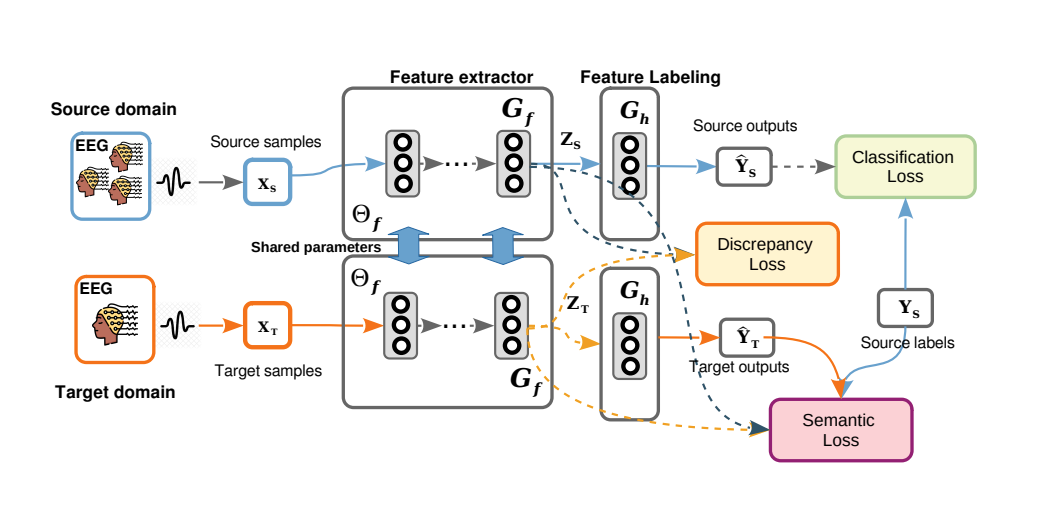

## Semantic Trasnfer Loss

In [ ]:
def Semantic(Xs, Xt, Ys, Yt, Cs_memory, Ct_memory, decay=0.3):
    # Clone memory
    Cs = Cs_memory.clone()
    Ct = Ct_memory.clone()

    # spherical normalization
    r = torch.norm(Xs, dim=1)[0]
    Ct = r * Ct / (torch.norm(Ct, dim=1, keepdim=True)+1e-10)
    Cs = r * Cs / (torch.norm(Cs, dim=1, keepdim=True)+1e-10)

    K = Cs.size(0)
    # for each class
    for k in range(K):

        # Get samples from class 'k'
        Xs_k = Xs[Ys==k]    # source domain
        Xt_k = Xt[Yt==k]    # target domain

        # validate if there is zero elements in Source domain
        if len(Xs_k)==0:
            Cs_k = 0.0
        else:
            # get mean from elements of the source domain
            Cs_k = torch.mean(Xs_k,dim=0)

        # validate if there is zero elements in Target domain
        if len(Xt_k) == 0:
            Ct_k = 0.0
        else:
            # get mean from elements of the target domain
            Ct_k = torch.mean(Xt_k,dim=0)

        # Moving average (MA)
        Cs[k, :] = (1 - decay) * Cs_memory[k, :] + decay * Cs_k
        Ct[k, :] = (1 - decay) * Ct_memory[k, :] + decay * Ct_k

    Dist = cosine_matrix(Cs, Ct)

    return torch.sum(torch.diag(Dist)), Cs, Ct

def cosine_matrix(x,y):
    x=F.normalize(x,dim=1)
    y=F.normalize(y,dim=1)
    xty=torch.sum(x.unsqueeze(1)*y.unsqueeze(0),2)
    return 1-xty

# Train

## Evaluation function

In [ ]:
def test(network_f, network_h, test_loader):
    start_test = True
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            # get batch data
            samples = data[0].float().cuda()
            labels = data[1].long().cuda()

            # Get features and predictions
            feats = network_f(samples)
            preds = network_h(feats)
            # probabilidad máxima
            predictions = preds.data.max(1)[1]

            if start_test:
                y_pred = predictions.cpu().numpy()
                y_true = labels.data.cpu().numpy()
                start_test = False
            else:
                y_pred = np.concatenate((y_pred, predictions.cpu().numpy()), 0)
                y_true = np.concatenate((y_true, labels.data.cpu().numpy()), 0)

        # Binarize ytest with shape (n_samples, n_classes)
        labels = np.unique(y_true)
        ytest = label_binarize(y_true, classes=labels)
        ypreds = label_binarize(y_pred, classes=labels)

        # compute utils
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        auc = roc_auc_score(ytest, ypreds, average='macro', multi_class='ovr')


    return acc, f1, auc

In [ ]:
def losocv(X, Y, subjects, args):
    """
        Leave One-Subject-Out Cross-Validation (LOOCV) on Cognitive Load data

        Params
            X: dataset containing all subject samples
            Y: dataset containing all subject labels
            subjects: dataset containing pairs between sample indexes and subjects
            args: hyper-parameters to train Custom Domain Adaptation.
    """

    # variable used to save accuracy results
    list_metrics_clsf = []
        
    # Extract pairs between indexes and subjects
    fold_pairs = get_subject_indices(subjects)
    
    # Iterate over fold_pairs
    for foldNum, fold in enumerate(fold_pairs):
        print('Beginning fold {0} out of {1}'.format(foldNum+1, len(fold_pairs)))

        # Only Subjects 1 and 2 are executed
        if foldNum+1 >= 2:# and foldNum+1 <= 11:
            continue

        # Get source and target datasets
        (x_src, y_src), (x_trg, y_trg), y_classes = split_losocv(X, Y, fold)

        # data shape
        print("x_src-shape:", x_src.shape, "y_src-shape:", y_src.shape)
        print("x_trg-shape:", x_trg.shape, "y_trg-shape:", y_trg.shape)
        print("classes:", y_classes)

        # [NUMPY TO TENSOR]
        Sx_tensor = torch.tensor(x_src)
        Sy_tensor = torch.tensor(y_src)
        Tx_tensor = torch.tensor(x_trg)
        Ty_tensor = torch.tensor(y_trg)

        # [CONTAINERS]
        # create container for source labeled data
        source = TensorDataset(Sx_tensor, Sy_tensor)
        # create container for labeled target data
        target = TensorDataset(Tx_tensor, Ty_tensor)

        # [BUILD DATA LOADERS]
        # target
        source_loader = DataLoader(source, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
        target_loader = DataLoader(target, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
        test_loader = DataLoader(target, batch_size=args.batch_size, shuffle=False, num_workers=4)

        # counter
        epoch = 1
        eval_iter = x_src.shape[0] // args.batch_size

        # [Build Model]
        hidden_size = 128
        network_f = Extractor().cuda()
        network_h = Predictor(input_size=hidden_size, n_classes=4).cuda()

        # [OPTIMIZERS]
        optimizer_f = optim.RMSprop(network_f.parameters(), lr=args.lr, weight_decay=0.001)
        optimizer_h = optim.RMSprop(network_h.parameters(), lr=args.lr, weight_decay=0.001)

        # [Classification loss]
        criterion = nn.CrossEntropyLoss().cuda()

        # [Central moment Discrepancy]
        cmd_loss = CMD(n_moments=2)

        Cs_memory = torch.zeros(4, hidden_size).cuda()
        Ct_memory = torch.zeros(4, hidden_size).cuda()

        # length of datasets
        len_train_source = len(source_loader)
        len_train_target = len(target_loader)

        # Almacenar pérdida
        list_loss = []

        for iter_num in range(0, args.max_iterations + 1):
            # print(iter_num)
            network_f.train()
            network_h.train()

            # Update loaders
            if iter_num % len_train_source == 0:
                data_iter_s = iter(source_loader)
            if iter_num % len_train_target == 0:
                data_iter_t = iter(target_loader)

            # get batch
            inputs_target, _ = next(data_iter_t)
            inputs_source, labels_source = next(data_iter_s)

            # TO CUDA
            inputs_source, inputs_target, labels_source = inputs_source.float().cuda(), inputs_target.float().cuda(), labels_source.long().cuda()

            # Extract features and outputs
            # Source domain
            features_source = network_f(inputs_source)
            outputs_source = network_h(features_source)

            # Target domain
            features_target = network_f(inputs_target)
            outputs_target = network_h(features_target)

            # Target pseudo-labels
            pseu_labels_target = torch.argmax(outputs_target, dim=1)

            # [CROSS-ENTROPY LOSS]
            classifier_loss = criterion(outputs_source, labels_source)

            # [CENTRAL MOMENT DISCREPANCY LOSS]
            transfer_loss = cmd_loss.forward(features_source, features_target)

            # [SEMANTIC TRANSFER LOSS]
            loss_sm, Cs_memory, Ct_memory = Semantic(features_source, features_target, labels_source, pseu_labels_target, Cs_memory, Ct_memory, decay=0.9)

            # [Total Loss]
            lambda_dis = 1.0
            lambda_cond = 0.1
            total_loss = classifier_loss + lambda_dis * transfer_loss + lambda_cond * loss_sm

            # Reset gradients
            optimizer_f.zero_grad()  # feature extractor
            optimizer_h.zero_grad()  # classifier

            # Barckpropagation
            total_loss.backward()

            # Update weights
            optimizer_f.step()
            optimizer_h.step()

            Cs_memory.detach_()
            Ct_memory.detach_()

            # append loss
            list_loss.append(total_loss.cpu().detach().numpy())

            # [EVALUATION]
            if iter_num % int(eval_iter) == 0 and iter_num > 0:

                network_f.eval()
                network_h.eval()
                acc, f1, auc = test(network_f, network_h, test_loader)
                avg_loss = np.array(list_loss).mean()
                print('Epoch: %d loss: %4f Acc: %.4f  F1-score: %.4f  AUC: %.4f' % (epoch, avg_loss, acc, f1, auc))
                epoch += 1
                list_loss = []


        print("\n")
        # add to list
        list_metrics_clsf.append([acc, f1, auc, foldNum+1])
    
    # To np array
    list_metrics_clsf = np.array(list_metrics_clsf)

    # Save Classification Metrics
    save_file = args.dir_resume+"/losocv-results.csv"
    f=open(save_file, 'ab')
    np.savetxt(f, list_metrics_clsf, delimiter=",", fmt='%0.4f')
    f.close()

In [ ]:
# run Leave One-Subject-Out Cross-Validation (LOSOCV)
losocv(X, y, subjects, args)

## Open results in csv

In [ ]:
import pandas as pd

df = pd.read_csv(args.dir_resume + "/losocv-results.csv")
print(df.to_string()) 